In [2]:
# Exécutez cette cellule pour installer votre Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:

!unzip '/content/drive/My Drive/WESAD/wesad39.zip'
!unzip 'S3.zip'
!unzip 'S4.zip'
!unzip 'S5.zip'
!unzip 'S6.zip'
!unzip 'S7.zip'
!unzip 'S8.zip'
!unzip 'S9.zip'



Archive:  /content/drive/My Drive/WESAD/wesad39.zip
  inflating: S6.zip                  
  inflating: S3.zip                  
  inflating: S4.zip                  
  inflating: S5.zip                  
  inflating: S7.zip                  
  inflating: S8.zip                  
  inflating: S9.zip                  
Archive:  S3.zip
  inflating: S3.pkl                  
Archive:  S4.zip
  inflating: S4.pkl                  
Archive:  S5.zip
  inflating: S5.pkl                  
Archive:  S6.zip
  inflating: S6.pkl                  
Archive:  S7.zip
  inflating: S7.pkl                  
Archive:  S8.zip
  inflating: S8.pkl                  
Archive:  S9.zip
  inflating: S9.pkl                  


In [4]:
!unzip '/content/drive/My Drive/WESAD/wesad1017.zip'
!unzip 'S10.zip'
!unzip 'S11.zip'
!unzip 'S13.zip'
!unzip 'S14.zip'
!unzip 'S15.zip'
!unzip 'S16.zip'
!unzip 'S17.zip'

Archive:  /content/drive/My Drive/WESAD/wesad1017.zip
  inflating: S17.zip                 
  inflating: S10.zip                 
  inflating: S11.zip                 
  inflating: S13.zip                 
  inflating: S14.zip                 
  inflating: S15.zip                 
  inflating: S16.zip                 
Archive:  S10.zip
  inflating: S10.pkl                 
Archive:  S11.zip
  inflating: S11.pkl                 
Archive:  S13.zip
  inflating: S13.pkl                 
Archive:  S14.zip
  inflating: S14.pkl                 
Archive:  S15.zip
  inflating: S15.pkl                 
Archive:  S16.zip
  inflating: S16.pkl                 
Archive:  S17.zip
  inflating: S17.pkl                 


In [8]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
a = open('S10.pkl', 'rb')
data = pickle.load(a,encoding='latin-1')


In [13]:
data['signal']['chest'].keys()

dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])


In [14]:
data['signal']['wrist'].keys()

dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

The WESAD Dataset contains physiological data from n subjects.
The data has been recorded in laboratory condition and is formed of :

  - Wrist Data :
  
    -  ACC : Accelerometer (32 Hz)
    - BVP  : Blood Volume Pulse (64 Hz)
    - EDA (Electro Dermal Activity) (4 Hz)
    - TEMP : Temperature du corps (4 Hz)

  - Chest Data :
    
    - ACC : Acclerometer (700 Hz)
    - ECG (Electro CardioGram) (700 Hz)
    - EDA (Electro Dermal Activity) (700 Hz)
    - EMG (Electro MyoGram) (700 Hz)
    - RESP : Respiration measured in %
    - TEMP : Body Temperature  


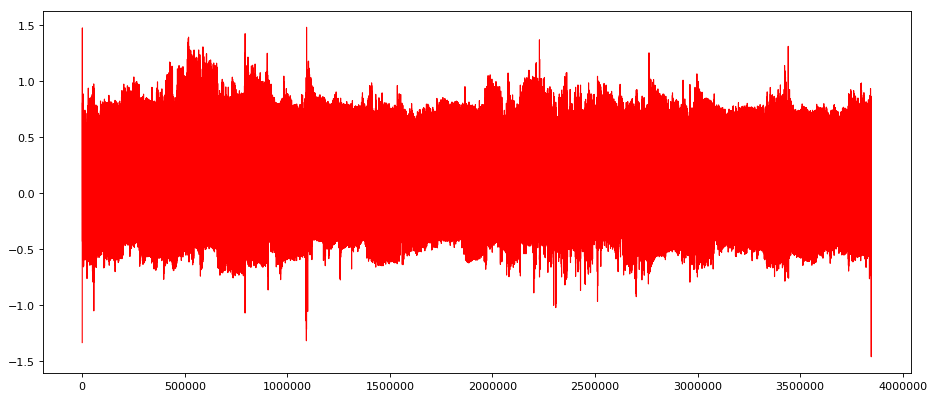

In [15]:
ecg = data['signal']['chest']['ECG'].flatten()
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(temp)
ax.plot(range(0,len(ecg)), ecg, color='red', animated = True, linewidth=1)


In [0]:
def load_subject(subject):
  
  a = open(subject+'.pkl', 'rb')
  data = pickle.load(a,encoding='latin-1')
  return data
  

As we will work on stress detection at work, we will work only on wrist data as it is a more practical approach in real life conditions.

The features of wrist data are synchronized at 32,64 and 4 Hz.

We will reduce all frequencies of wrist data to 4 Hz.

In [0]:
'''  Reduction de dimensions  '''

def reduce_dim(att,data):
  if att == 'EDA' or att == 'TEMP' :
    return data['signal']['wrist'][att]
  
  HZ4 = data['signal']['wrist']['EDA'].shape[0]
  ratio = data['signal']['wrist'][att].shape[0]/HZ4
  lst=np.array([data['signal']['wrist'][att][0]])
  print(lst)
  s=0
  for i in range(2,data['signal']['wrist'][att].shape[0]):
    if i%ratio==1:
      lst=np.concatenate((lst,[data['signal']['wrist'][att][i-1]]), axis = 0)
      s=s+1
  lst = lst.astype('float32')
  return lst

In [0]:
'''   Synchronisation a 4 hz des inputs '''
def sync_inputs(data):
  acc = reduce_dim('ACC',data)
  don = np.array(acc)
  don = don[:20000,:]
  attributes = np.array(list(data['signal']['wrist'].keys()))
  attributes = attributes[attributes != 'ACC']
  for attr in attributes :
    #print(attr)
    if attr != 'EDA' and attr != 'TEMP' :
      a=reduce_dim(attr,data)
    else :
      a=data['signal']['wrist'][attr]
    a=a[:20000,:]
    don = np.concatenate((don,a), axis=1)
    #print(don)
  return don

In [0]:
'''   Synchronisation a 4 hz des outputs '''

def sync_outputs(data):
  
  rate = len(data['label'])/data['signal']['wrist']['TEMP'].shape[0]
  lst=np.array([data['label'][0]])
  a=[]
  s=0
  for i in range(0,len(data['label'])):
    ratio = 1 if data['label'][i]==0 else data['label'][i] 
    a.append(data['label'][i])
    if i%rate==0:
      lst=np.concatenate((lst,[data['label'][i-1]]), axis = 0)
      a=[]
  
  lst=lst[:20000]
  lst = lst.reshape(20000,1)
  return lst

In [0]:
'''  Concatene tous les sujets  '''

def load_group(filenames, device):
  loaded = np.array([[]])
  #loaded_target = np.empty((20000,1))
  loaded_target = np.array([[]])
  print(loaded)
  firstIter = True
  s=0
  taille=0
  synchronize = []
  target = []
  for name in filenames :
    data = load_subject(name)
    synchronize = sync_inputs(data)
    taille = taille + synchronize.shape[0]
    target = sync_outputs(data)
    if firstIter : 
      loaded_target = target
      loaded = synchronize
      firstIter = False
    else :
      loaded_target = np.concatenate((loaded_target,target), axis = 0)
      loaded_target = loaded_target.astype('int32')
      loaded = np.concatenate((loaded,synchronize), axis = 0)

    s=s+target.shape[0]
  loaded.reshape((taille,6))
  loaded_target.reshape((s,1))

  return {'input':loaded, 'target':loaded_target}

In [0]:
def preprocessing():
  filenames = ['S3,'S4','S5','S6','S5','S6','S7','S8','S9',S10','S11','S13','S14','S15','S16','S17']
  return load_group(filenames,'wrist')

In [0]:
pd.DataFrame(d['input']).to_csv("in1017.csv")
!cp in1017.csv drive/My\ Drive/
pd.DataFrame(d['target']).to_csv("tr1017.csv")
!cp tr1017.csv drive/My\ Drive/

In [0]:
from google.colab import files
files.download('inwr.csv') 
files.download('trwr.csv') 

In [0]:
pd.DataFrame(d['input']).to_csv("in39.csv")
!cp in39.csv drive/My\ Drive/
pd.DataFrame(d['target']).to_csv("tr39.csv")
!cp tr39.csv drive/My\ Drive/